# Visualizing champion difficulty and hyper-carriness

This notebook explores which League of Legends champions are easiest and most challenging to play; and which champions are best in the early game versus the late game. It is part of my [project to analyze LoL using maching learning](http://github.com/map222/lolML). My summoner IDs are Umiy and lemmingo.

First, we need to import some libraries

In [1]:
import requests
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import re
import numpy as np
import src.plotting as lol_plt
import pdb
import ast

Next we need to load a list of champions; I output it here so you can remake it yourself. Note that Wukong is the 'monkeyking.'

In [2]:
champ_list = pd.read_csv('../champ list.csv', header=None)
champ_list.columns = ['Champion']
champ_list.Champion = champ_list.Champion.str.lower()
champ_list.Champion = champ_list.Champion.str.replace('[^\w]','')
print(champ_list.Champion.tolist(), )
champ_list.drop(49, inplace=True) # drop kindred due to lack of data

['ahri', 'akali', 'alistar', 'amumu', 'anivia', 'annie', 'ashe', 'azir', 'bard', 'blitzcrank', 'brand', 'braum', 'caitlyn', 'cassiopeia', 'chogath', 'corki', 'darius', 'diana', 'drmundo', 'draven', 'ekko', 'elise', 'evelynn', 'ezreal', 'fiddlesticks', 'fiora', 'fizz', 'galio', 'gangplank', 'garen', 'gnar', 'gragas', 'graves', 'hecarim', 'heimerdinger', 'irelia', 'janna', 'jarvaniv', 'jax', 'jayce', 'jinx', 'kalista', 'karma', 'karthus', 'kassadin', 'katarina', 'kayle', 'kennen', 'khazix', 'kindred', 'kogmaw', 'leblanc', 'leesin', 'leona', 'lissandra', 'lucian', 'lulu', 'lux', 'malphite', 'malzahar', 'maokai', 'masteryi', 'missfortune', 'mordekaiser', 'morgana', 'nami', 'nasus', 'nautilus', 'nidalee', 'nocturne', 'nunu', 'olaf', 'orianna', 'pantheon', 'poppy', 'quinn', 'rammus', 'reksai', 'renekton', 'rengar', 'riven', 'rumble', 'ryze', 'sejuani', 'shaco', 'shen', 'shyvana', 'singed', 'sion', 'sivir', 'skarner', 'sona', 'soraka', 'swain', 'syndra', 'tahmkench', 'talon', 'taric', 'teemo'

To get the champion data, we're going to query [League of Graphs](http://www.leagueofgraphs.com/). For each champion, we're going to create a URL for that champions webpage, and then make a list of html pages that we can use later. The html pages will have all the numbers we care about.

In [ ]:
champ_html = [requests.get('http://www.leagueofgraphs.com/champions/stats/'+ cur_champ) for cur_champ in list(champ_list['Champion'])]

## Load / save from pickle

To save time (and League of Graph's bandwidth), we can save the html to our computer, or load it from the computer. Note that we have to delete Kindred at the moment because there isn't enough data.

In [17]:
with open('champ_html.pickle', 'wb') as champ_pickle:
    pickle.dump(champ_html, champ_pickle)

In [3]:
with open('../champ_html.pickle', 'rb') as champ_pickle:
    champ_html = pickle.load(champ_pickle)

In [4]:
del champ_html[49] # delete kindred

## What champions are easiest and most difficult?

Now that we have the data loaded into our html list, we can begin analyzing it. First, we need to extract the data for win rates versus time. To do this, I use a regular expression to find the variable d8, and then use eval to get it. (There is probably a more elegant Pythonic way to convert strings to lists.)

In [5]:
def get_wins_by_games(html):
    win_by_games_str = re.search('(?<=var d8 = ).*?]]', html).group(0)
    win_by_games_list = ast.literal_eval(win_by_games_str)
    return win_by_games_list

Apply the get_wins_by_games function to the html list using list comprehension.

In [6]:
wins_by_games = np.array([get_wins_by_games(x.text) for x in champ_html])

To get a sense of what these look like, we can plot the win rates versus time for random champions. First we define the plot function (which we'll reuse), and then apply it to wins_by_games.

In [7]:
def plot_wins_by_index( wins_by_index):
    for cur_game in wins_by_index:
        win_index, percent = zip(*cur_game)
        plt.plot(win_index, percent, 'grey')
    plt.ylabel('Win rate', fontsize = 18)
    lol_plt.prettify_axes(plt.gca())

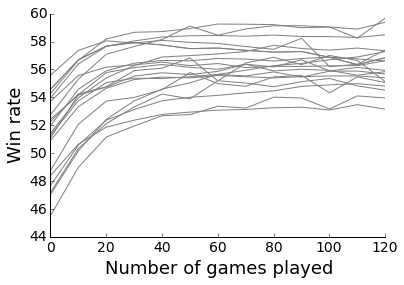

In [8]:
plot_wins_by_index( wins_by_games[np.random.randint(0, 125, 20)])
plt.xlabel('Number of games played', fontsize = 18);

The win rates for most champions increases as people play them more. To create a metric for the learning curve, we can subtract the maximum winrate from the minimum winrate.

In [6]:
def get_learn_delta(game):
    _, percent = zip(*game)
    return max(percent) - min(percent)

Then we can apply it using a list comprehension.

In [9]:
learn_deltas = [get_learn_delta(x) for x in wins_by_games]
learn_deltas = np.array(learn_deltas)
champ_list['learn_delta'] =learn_deltas

Finally,  we can plot the histogram of the change in win rate with experience.

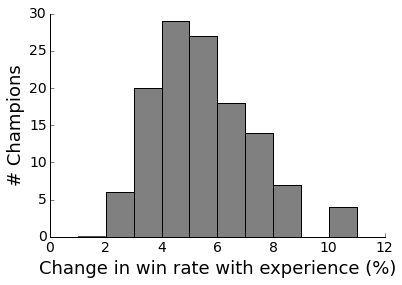

In [68]:
plt.hist(learn_deltas, bins=range(1,12), color = 'grey');
plt.xlabel('Change in win rate with experience (%)', fontsize = 18)
plt.ylabel('# Champions', fontsize = 18)
lol_plt.prettify_axes(plt.gca())

Everyone gets at least 2-3 percent better with experience, with a few notable outliers at 10%! Now we can investigate which champions have the highest learning curve. That is they have the biggest change in winrate.

In [10]:
high_skill_champs = np.where(learn_deltas > 8.5)
champ_list.iloc[high_skill_champs]

,Champion,learn_delta
7,azir,10.45
8,bard,8.59
41,kalista,10.22
77,reksai,10.08
79,rengar,10.25
82,ryze,8.90
99,thresh,8.57


This list looks pretty intuitive! Many highly mechanical champions like Azir and Rengar, and strategically different champions like Bard and Rek'Sai. Ryze is a surprisingly difficult champion apparently! Let's plot these champions win rate as a function of games played.

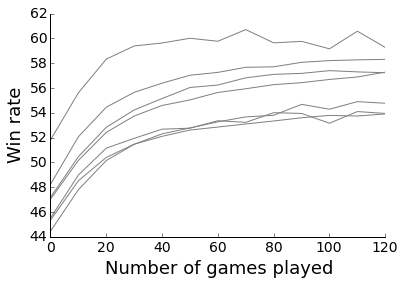

In [45]:
plot_wins_by_index(wins_by_games[high_skill_champs])
plt.xlabel('Number of games played', fontsize = 18);

Those are indeed steep learning curves.

Now we can turn to low skill champs, and repeat the same procedure.

In [46]:
low_skill_champs = np.where(learn_deltas < 3)
champ_list.iloc[low_skill_champs]

,Champion,learn_delta
27,galio,2.09
42,karma,2.87
46,kayle,2.65
58,malphite,2.91
63,mordekaiser,2.26
97,taric,2.64


These results look intuitive as well. What about their learning curves?

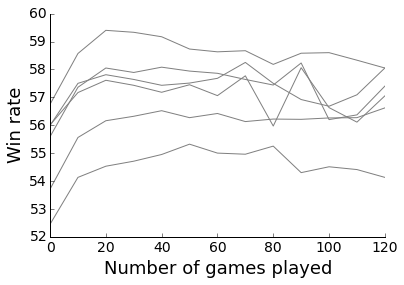

In [48]:
plot_wins_by_index(wins_by_games[low_skill_champs])
plt.xlabel('Number of games played', fontsize = 18);

Most of these champions can be effectively mastered in twenty games. If you're looking to pick up ELO late in the season, you might try one of these. The high one here is Kayle.

# Which champions are best early in the game, and late in the game?

We can perform a similar analysis to see which champions are late game carries, and which are best early in the game. First, we again use regular expressions on the html to get the win rates as a function of time..

In [11]:
def get_wins_by_time(html):
    wins_by_time_str = re.search('(?<=var d7 = ).*?]]', html).group(0)
    wins_by_time_list = ast.literal_eval(wins_by_time_str)
    return wins_by_time_list

In [12]:
wins_by_time =  np.array([get_wins_by_time(x.text) for x in champ_html])

Now we can plot the win rate as a function of time for some random champions.

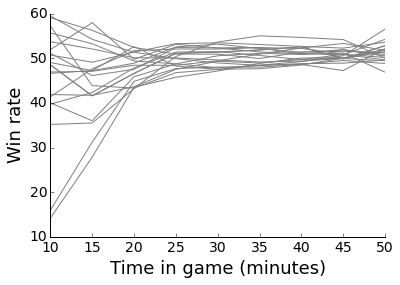

In [53]:
plot_wins_by_index( wins_by_time[np.random.randint(0, 125, 20)])
plt.xlabel('Time in game (minutes)', fontsize = 18);

Id you ignore the variation at 10 minutes (due to small sample sizes), the curves seem pretty flat.

This time, let's define the late game criterion as the change in win rate between 20 and 35 minutes (over 75% of games end by around 35-40 minutes).

In [13]:
def get_time_delta(game):
    _, percent = zip(*game)
    return percent[2] - percent[5] # win rate at 20 vs win rate at 35

We apply this function to the list, and add it to our dataframe.

In [14]:
time_deltas = [get_time_delta(x) for x in wins_by_time]
time_deltas = np.array(time_deltas)
champ_list['time_delta'] = time_deltas

Now we can plot the distribution of values.

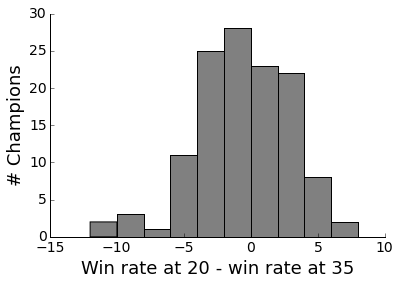

In [61]:
plt.hist(time_deltas, bins=range(-12, 10, 2), color = 'grey');
plt.xlabel('Win rate at 20 - win rate at 35', fontsize = 18)
plt.ylabel('# Champions', fontsize = 18)
lol_plt.prettify_axes(plt.gca())

Most champions are with +/-5% win rate over the course ofo the game. Notably, there are some deep outliers around -10%!

Now we can look at the early game champions.

In [15]:
early_champs = np.where(time_deltas >5)
champ_list.iloc[early_champs]

,Champion,learn_delta,time_delta
4,anivia,5.68,6.37
9,blitzcrank,5.21,5.56
51,leblanc,7.12,5.21
52,leesin,5.51,5.84
73,pantheon,3.77,6.67


This list looks pretty good. Blitzcrank, Lee Sin, and Pantheon are all strong in the early game. The presence of Anivia is somewhat surprising here, as people often build Rod of Ages on her. Let's plot their win rate versus time.

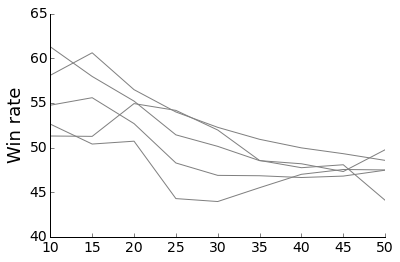

In [64]:
plot_wins_by_index( wins_by_time[early_champs])

Just what we expected, these champions win  the most in the early game, and peter out later.

Now we can turn to the late game champs.

In [65]:
late_champs = np.where(time_deltas < -6)
champ_list.iloc[late_champs]

,Champion,learn_delta,time_delta
7,azir,10.45,-11.35
13,cassiopeia,7.38,-8.08
38,jax,4.59,-6.91
74,poppy,3.82,-8.53
115,warwick,4.39,-11.81
120,yorick,4.11,-8.22


This list also looks intuitive, with notorious hyper-scaling carries like Azir, Cassiopeia, Jax, and Poppy. I was kinda surprised by the presence of Warwick given his strong level 6 ganking, perhaps people take a long time to stack his Devourer enchantment.

Let's plot their winrate.

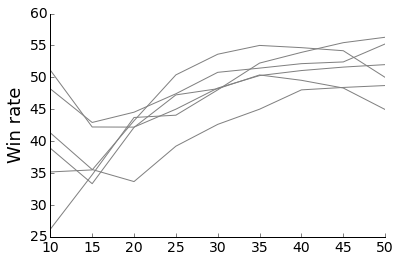

In [66]:
plot_wins_by_index( wins_by_time[late_champs])

All of these champions gain in win rate as the game goes on. They all have extremely mediocre early games to boot. You probably don't want to get too many of these on one team. That's all for this notebook!

## Bonus table
I didn't want to clutter the main notebook with a large table. Here are the champions sorted by difficulty from hardest to easiest (there is a gap for middle difficulty champions since the list is large.)

In [17]:
champ_list.sort('learn_delta', ascending = False)

,Champion,learn_delta,time_delta
7,azir,10.45,-11.35
79,rengar,10.25,-3.23
41,kalista,10.22,-0.54
77,reksai,10.08,1.30
82,ryze,8.90,-3.29
8,bard,8.59,-4.20
99,thresh,8.57,2.10
22,evelynn,8.25,-1.31
94,syndra,8.19,3.23
68,nidalee,8.19,-0.56
